In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import dates as mpl_dates

In [2]:
data = pd.read_csv("ETH.csv").drop(["slug","name","symbol","ref_cur","time_open","time_close","time_high","time_low","id","market_cap"],axis=1)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data.rename({'timestamp':'date'},axis=1)

In [3]:
data['date'] = data['date'].astype('str') 
data['date'] = data['date'].map(lambda x: x.rstrip('23:59:59'))
data['date'] = pd.to_datetime(data['date'])
data

,date,open,high,low,close,volume
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,1.643290e+05
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,6.741880e+05
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,5.321700e+05
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,4.052830e+05
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.463100e+06
...,...,...,...,...,...,...
2365,2022-01-27,2467.188460,2510.451687,2328.452267,2423.001263,1.612652e+10
2366,2022-01-28,2421.646910,2548.778569,2367.833737,2547.091978,1.466623e+10
2367,2022-01-29,2546.590514,2627.609410,2526.989644,2597.084692,1.117206e+10
2368,2022-01-30,2598.564990,2631.408416,2550.461009,2603.466582,9.501221e+09


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2370 entries, 0 to 2369
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2370 non-null   datetime64[ns]
 1   open    2370 non-null   float64       
 2   high    2370 non-null   float64       
 3   low     2370 non-null   float64       
 4   close   2370 non-null   float64       
 5   volume  2370 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 111.2 KB


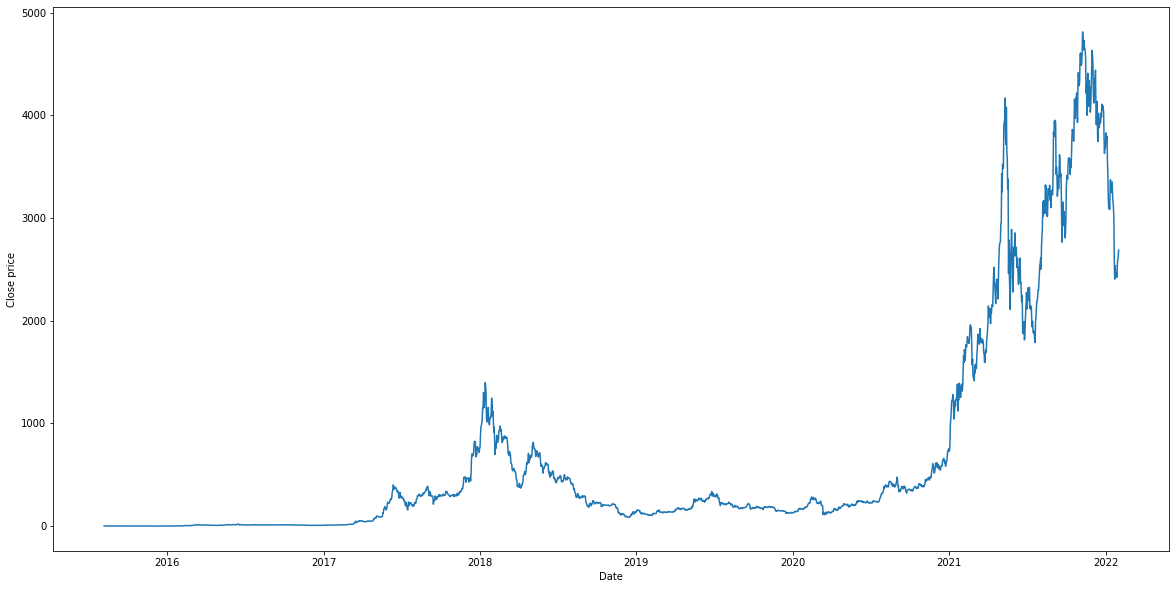

In [5]:
plt.figure(figsize=(20,10))
plt.plot(data['date'],data['close'])
plt.xlabel('Date')
plt.ylabel('Close price')
plt.show()

In [6]:
n = len(data)
n

2370

In [7]:
data['label'] = ''
for i in range(len(data)) :
  if i+1 < n :
    data['label'][i+1] = data['close'][i+1] / data['close'][i]

<ipython-input-7-30c4662e37d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'][i+1] = data['close'][i+1] / data['close'][i]


In [8]:
data['Y'] = ''
for i in range(len(data)) :
  if i+1 < n :
    if data['label'][i+1] > 1 :
      data['Y'][i+1] = 1
    else : 
      data['Y'][i+1] = 0

<ipython-input-8-c4ac8a02e2c7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Y'][i+1] = 0
<ipython-input-8-c4ac8a02e2c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Y'][i+1] = 1


# **Input Indicator**

In [9]:
t_period = 10

## **SMA**

In [10]:
data['sma10'] = ''
data['sma10'] = data['close'].rolling(t_period).mean()

## **WMA**

In [11]:
weights = np.arange(1,11)
weights

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [12]:
data['wma10'] = ''
data['wma10'] = data['close'].rolling(t_period).apply(lambda close: np.dot(close, weights)/weights.sum(), raw=True)

## **MACD**

In [13]:
exp1 = data['close'].ewm(span = 12 , adjust = False , min_periods=12).mean()
exp2 = data['close'].ewm(span = 26 , adjust = False , min_periods=26).mean()
macd = exp1 - exp2
data['MACD'] = macd

## **%K**

In [14]:
k_period = 14
# Adds a "n_high" column with max value of previous 14 periods
n_high = data['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
n_low = data['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
data['%K'] = (data['close'] - n_low)  / (n_high - n_low) * 100

## **RSI**

In [15]:
def rsi(data, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = data['close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [16]:
data['RSI'] = rsi(data, periods = 14, ema = True)

## **%R**

In [17]:
def get_wr(high, low, close, periods = 14):
    highh = high.rolling(14).max() 
    lowl = low.rolling(14).min()
    wr = -100 * ((highh - close) / (highh - lowl))
    return wr

data['%R'] = get_wr(data['high'], data['low'], data['close'], periods = 14)

# **Model**

In [18]:
data = data.dropna()

In [19]:
data = data.astype({"Y":int})

In [20]:
data

,date,open,high,low,close,volume,label,Y,sma10,wma10,MACD,%K,RSI,%R
25,2015-09-01,1.353480,1.392740,1.336630,1.351610,7.788620e+05,0.995119,0,1.243478,1.260630,-0.193357,58.589932,43.772935,-41.410068
26,2015-09-02,1.351570,1.354910,1.264620,1.294790,8.837690e+05,0.957961,0,1.237698,1.269960,-0.179722,47.101644,41.931344,-52.898356
27,2015-09-03,1.295190,1.309990,1.211030,1.264930,7.029910e+05,0.976938,0,1.241064,1.274911,-0.169373,41.064315,40.956172,-58.935685
28,2015-09-04,1.264930,1.302520,1.236810,1.274410,4.743910e+05,1.007494,1,1.254486,1.280974,-0.158579,51.275983,41.421951,-48.724017
29,2015-09-05,1.280560,1.342300,1.271190,1.338810,4.484530e+05,1.050533,1,1.272369,1.296306,-0.143177,79.621677,44.618160,-20.378323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2365,2022-01-27,2467.188460,2510.451687,2328.452267,2423.001263,1.612652e+10,0.981755,0,2654.644170,2527.256987,-323.652279,20.820538,26.466646,-79.179462
2366,2022-01-28,2421.646910,2548.778569,2367.833737,2547.091978,1.466623e+10,1.051214,1,2592.950842,2507.702043,-311.996970,31.126220,32.790884,-68.873780
2367,2022-01-29,2546.590514,2627.609410,2526.989644,2597.084692,1.117206e+10,1.019627,1,2543.076728,2508.453652,-295.321774,35.278093,35.208536,-64.721907
2368,2022-01-30,2598.564990,2631.408416,2550.461009,2603.466582,9.501221e+09,1.002457,1,2503.311382,2519.433626,-278.382575,36.430824,35.527372,-63.569176


In [21]:
X = data[['sma10','wma10','MACD','%K','RSI','%R']].to_numpy()
y = data.Y.to_numpy()

In [22]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [23]:
for train_index, test_index in tscv.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [24]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1955, 6) (390, 6) (1955,) (390,)


## Decision Tree

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {
    'ccp_alpha': np.arange(0.001,0.1,0.001),
    'max_depth': range(2,6),
    'min_samples_split': range(2,6),
    'min_samples_leaf': range(2,6)
}

clf = DecisionTreeClassifier()
gs_clf = GridSearchCV(
    clf,
    param_grid=params,
    scoring='accuracy',
    cv=tscv
)

gs_clf.fit(X_train[0:1953],y_train[1:1954])
y_pred = gs_clf.predict(X_test)

In [31]:
gs_clf.best_params_

{'ccp_alpha': 0.001,
 'max_depth': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [32]:
from sklearn.metrics import classification_report as clf_report

print(clf_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.29      0.34       181
           1       0.51      0.63      0.56       209

    accuracy                           0.47       390
   macro avg       0.46      0.46      0.45       390
weighted avg       0.46      0.47      0.46       390



C:\Users\NONGBON\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


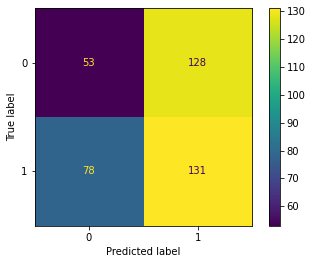

In [33]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gs_clf, X_test, y_test)  
plt.show()

## Random Forest

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params2 = {
    'n_estimators': range(50,150,10),
    'ccp_alpha': np.arange(0.001,0.1,0.001),
    'max_depth': range(2,6),
    'min_samples_split': range(2,4),
    'min_samples_leaf': range(1,4)
}

clf2 = RandomForestClassifier()
gs_clf2 = GridSearchCV(
    clf2,
    param_grid=params2,
    scoring='accuracy',
    cv=tscv
)

gs_clf2.fit(X_train[0:1953],y_train[1:1954])
y_pred2 = gs_clf2.predict(X_test)

In [29]:
from sklearn.ensemble import RandomForestClassifier
clf99 = RandomForestClassifier(n_estimators=90 , ccp_alpha=0.004 , max_depth=4 , min_samples_split=2 , min_samples_leaf=1)
clf99.fit(X_train[0:1953],y_train[1:1954])
y_pred2 = clf99.predict(X_test)

C:\Users\NONGBON\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


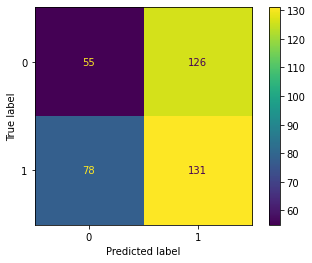

In [30]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf99, X_test, y_test)  
plt.show()

In [31]:
from sklearn.metrics import classification_report as clf_report
print(clf_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.41      0.30      0.35       181
           1       0.51      0.63      0.56       209

    accuracy                           0.48       390
   macro avg       0.46      0.47      0.46       390
weighted avg       0.47      0.48      0.46       390



## XGB

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

params3 = {
    'n_estimators': range(50,150,10),
    'max_depth': range(2,6),
    'eta' : np.arange(0.01,0.3,0.01),
    'gamma' : np.arange(0.01,0.2,0.01)
}

clf3 = XGBClassifier()
gs_clf3 = GridSearchCV(
    clf3,
    param_grid=params3,
    scoring='accuracy',
    cv=tscv
)

gs_clf3.fit(X_train[0:1953],y_train[1:1954])
y_pred3 = gs_clf3.predict(X_test)

In [ ]:
gs_clf3.best_params_

In [ ]:
from sklearn.metrics import classification_report as clf_report
print(clf_report(y_test, y_pred3))

## ExtraTree

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

params = {
     'n_estimators': range(50,150,10),
    'ccp_alpha': np.arange(0.001,0.1,0.001),
    'max_depth': range(2,6),
    'min_samples_split': range(2,4),
    'min_samples_leaf': range(1,4)
}

clf4 = ExtraTreesClassifier()
gs_clf4 = GridSearchCV(
    clf4,
    param_grid=params,
    scoring='accuracy',
    cv=tscv
)

gs_clf4.fit(X_train[0:1953],y_train[1:1954])
y_pred4 = gs_clf4.predict(X_test)

In [26]:
gs_clf4.best_params_

{'ccp_alpha': 0.001,
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 60}

In [28]:
from sklearn.metrics import classification_report as clf_report
print(clf_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.53      0.61      0.57       181
           1       0.61      0.54      0.58       209

    accuracy                           0.57       390
   macro avg       0.57      0.57      0.57       390
weighted avg       0.58      0.57      0.57       390



C:\Users\NONGBON\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


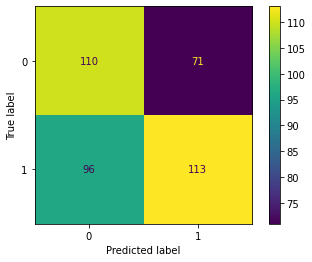

In [29]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gs_clf4, X_test, y_test)  
plt.show()